In [271]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [272]:
import datetime as dt

import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [273]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [274]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [275]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [276]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [277]:
# Save references to each table

# Manual code (let's do it programmatically instead)
# Measurement = Base.classes.measurement
# Station = Base.classes.station

# Programmatically
# Iterate over the reflected classes dict items, generate the class name by
# title-casing the key, and removing any spaces and underscores.  Then add to
# the class to the globals under that name.
for key, class_ in Base.classes.items():
    name = key.title().replace('_', '').replace(' ', '')
    globals()[name] = class_

# Make sure programatic code worked.
assert 'Measurement' in globals()
assert 'Station' in globals()

In [278]:
# List tables, columns, and column types for each table and column in the db
for table in inspector.get_table_names():
    columns = inspector.get_columns(table)
    for column in columns:
        print(f'{table}.{column['name']}: {column['type']}')

measurement.id: INTEGER
measurement.station: TEXT
measurement.date: TEXT
measurement.prcp: FLOAT
measurement.tobs: FLOAT
station.id: INTEGER
station.station: TEXT
station.name: TEXT
station.latitude: FLOAT
station.longitude: FLOAT
station.elevation: FLOAT


In [279]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [280]:
# Find the most recent date in the data set.

# Note: sqlite doesn't have date, time, or datetime types.  After inspecting the
# data, it's clear the date is stored as a string in format `YYYY-MM-DD`, which
# sorts the same lexicographically as chronologically, so max(date) will work.
# A different date format would have required more work.
date_format = '%Y-%m-%d'
def str2date(str_date):
    return dt.datetime.strptime(str_date, date_format).date()
(most_recent := session.query(func.max(Measurement.date)).first()[0])
most_recent_date = str2date(most_recent)

In [281]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
oldest_date_subquery = session.query(
    func.date(func.max(Measurement.date), '-12 months')
).scalar_subquery()

query = session.query(Measurement.date, func.sum(Measurement.prcp))\
    .filter(Measurement.prcp.is_not(None))\
    .filter(Measurement.date >= oldest_date_subquery)\
    .group_by(Measurement.date)\
    .order_by(Measurement.date)

# Debug the query
# print(str(query))

# Perform a query to retrieve the data and precipitation scores
(data := query.all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])
df['Date'] = df['Date'].map(str2date)

# Sort the dataframe by date
df = df.sort_values(by='Date').set_index('Date')
df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


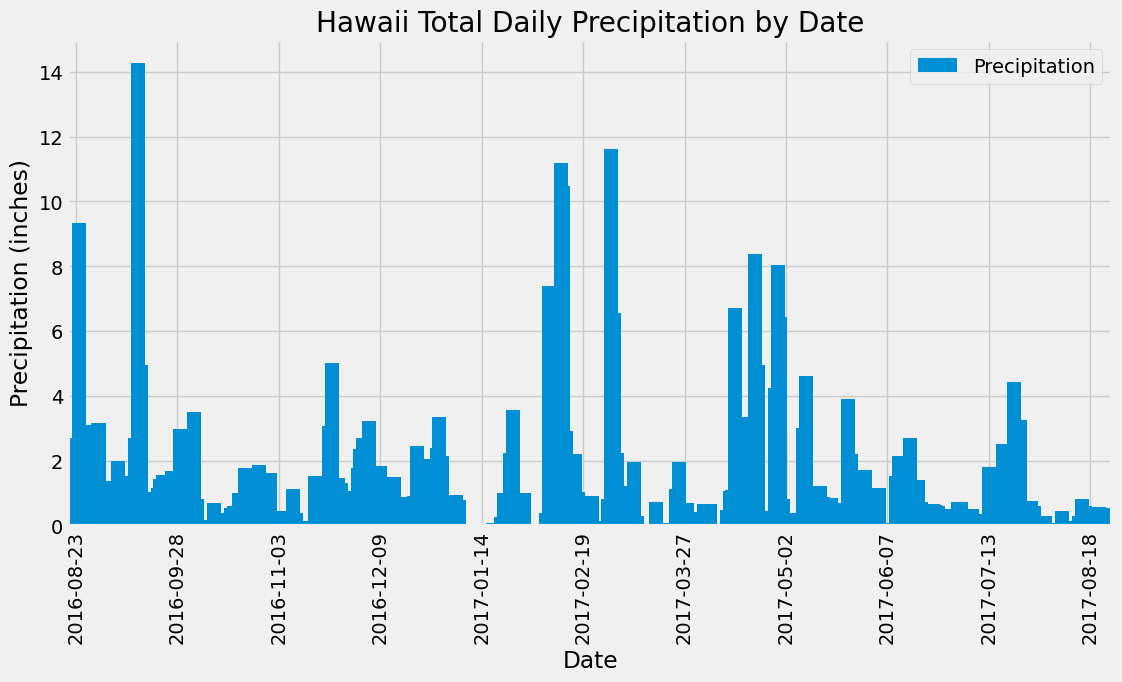

In [282]:
# Use Pandas Plotting with Matplotlib to plot the data
step = len(df)//10
plot = df.plot(kind="bar", figsize=(12, 6), width=5)

# Set the title and y-axis label
plot.set_title('Hawaii Total Daily Precipitation by Date')
plot.set_ylabel('Precipitation (inches)')

# Trick the xticks using slicing, so it only displays around 10 labels instead
# of a label for each individual date
plot.set_xticks(range(0, len(df), step))
plot.set_xticklabels(df.index[::step], rotation=90)

plt.show()

In [283]:
# Use Pandas to calculate the summary statistics for the precipitation data
(precipitation_stats := df['Precipitation'].describe())

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [284]:
# Design a query to calculate the total number of stations in the dataset
query = session.query(func.count(func.distinct(Station.id)))
# print(str(query))  # debug query
num_stations = query.first()[0]
num_stations

9

In [285]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(
        Station.station, Station.name,
        func.count(func.distinct(Measurement.id)).label('observation_count'),
    )\
    .filter(Measurement.station == Station.station)\
    .group_by(Station.station, Station.name)\
    .order_by(desc('observation_count'))

# print(str(query))  # debug query

active_stations = query.all()
for station in active_stations:
    name, observations = station.name, station.observation_count
    print(f"Station: {name}, Observations: {observations}")
most_active_station = active_stations[0]

Station: WAIHEE 837.5, HI US, Observations: 2772
Station: WAIKIKI 717.2, HI US, Observations: 2724
Station: KANEOHE 838.1, HI US, Observations: 2709
Station: WAIMANALO EXPERIMENTAL FARM, HI US, Observations: 2669
Station: MANOA LYON ARBO 785.2, HI US, Observations: 2612
Station: KUALOA RANCH HEADQUARTERS 886.9, HI US, Observations: 2202
Station: HONOLULU OBSERVATORY 702.2, HI US, Observations: 1979
Station: PEARL CITY, HI US, Observations: 1372
Station: UPPER WAHIAWA 874.3, HI US, Observations: 511


In [286]:
# Using the most active station id from the previous query, calculate the
# lowest, highest, and average temperature.
query = session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp'),
    )\
    .filter(Measurement.station == most_active_station.station)

# print(str(query))

temps = query.first()
print(f"Min temp: {temps.min_temp}")
print(f"Max temp: {temps.max_temp}")
print(f"Avg temp: {temps.avg_temp}")

Min temp: 54.0
Max temp: 85.0
Avg temp: 71.66378066378067


In [287]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
oldest_date_subquery = session.query(
       func.date(func.max(Measurement.date), '-12 months')
    )\
    .filter(Measurement.station == active_stations[0].station)\
    .scalar_subquery()

query = session.query(Measurement.date, func.sum(Measurement.tobs))\
    .filter(Measurement.station == most_active_station.station)\
    .filter(Measurement.tobs.is_not(None))\
    .filter(Measurement.date >= oldest_date_subquery)\
    .group_by(Measurement.date)\
    .order_by(Measurement.date)

# Perform a query to retrieve the data and precipitation scores
(data := query.all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
most_active_df = pd.DataFrame(data, columns=['Date', 'Temperature'])
most_active_df['Date'] = most_active_df['Date'].map(str2date)

# Sort the dataframe by date
most_active_df = most_active_df.sort_values(by='Date').set_index('Date')
most_active_df.describe()

,Temperature
count,357.000000
mean,73.196078
std,4.759460
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


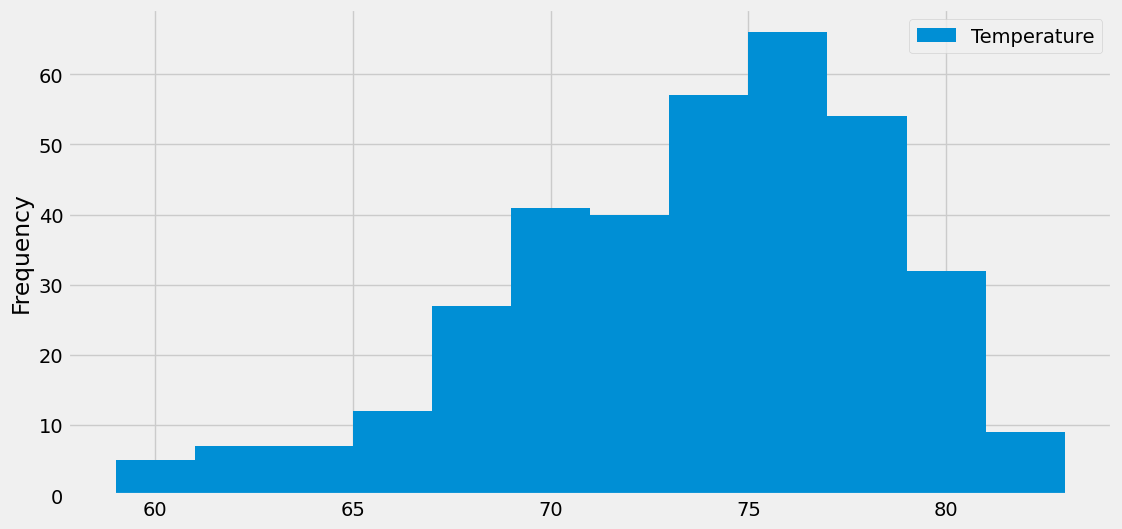

In [288]:

# Plot a 12 bin histogram
plot = most_active_df.plot(kind='hist', bins=12, figsize=(12, 6))

plt.show()

# Close Session

In [289]:
# Close Session
session.close()